<a href="https://colab.research.google.com/github/gustavohroos/treinamento-h2ia/blob/main/decision-tree/decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from collections import Counter

In [116]:
# X, y = load_iris(return_X_y=True)
X, y = load_wine(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [117]:
def entropy(y):
    ocurrences = np.bincount(y)
    percents = ocurrences / len(y)
    return -np.sum([p * np.log2(p) for p in percents if p > 0])

In [118]:
def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common

In [119]:
class Node:

    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf(self):
        return self.value is not None

In [120]:
class Decision_Tree:

    def __init__(self, max_depth=100, min_samples_split=2, num_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.num_features = num_features
        self.root = None
        self.depth = 0

    def fit(self, X, y):
        self.num_features = X.shape[1] if not self.num_features else min(self.num_features, X.shape[1])
        self.root = self.create_tree(X, y)

    def predict(self, X):
        return np.array([self.traverse_tree(x, self.root) for x in X])

    def create_tree(self, X, y, depth=0):
        num_samples, num_features = X.shape
        num_labels = len(np.unique(y))

        if (depth >= self.max_depth
                or num_labels == 1
                or num_samples < self.min_samples_split):
            leaf_value = most_common_label(y)
            return Node(value=leaf_value)

        feat_indexes = np.random.choice(num_features, self.num_features, replace=False)
        best_feature, best_threshold = self.select_best_feature(X, y, feat_indexes)

        left_indexes, right_indexes = self.split(X[:, best_feature], best_threshold)
        left = self.create_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self.create_tree(X[right_indexes, :], y[right_indexes], depth+1)
        return Node(best_feature, best_threshold, left, right)

    def split(self, X_column, split_threshold):
        left_indexes = np.argwhere(X_column <= split_threshold).flatten()
        right_indexes = np.argwhere(X_column > split_threshold).flatten()
        return left_indexes, right_indexes

    def select_best_feature(self, X, y, feature_indexes):
        best_gain = -1
        for index in feature_indexes:
            X_column = X[:, index]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self.information_gain(y, X_column, threshold)
                if gain > best_gain:
                    best_gain = gain
                    split_index = index
                    split_threshold = threshold

        return split_index, split_threshold

    def traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)

    def information_gain(self, y, X_column, threshold):
        parent_entropy = entropy(y)

        left_indexes, right_indexes = self.split(X_column, threshold)

        if len(left_indexes) == 0 or len(right_indexes) == 0: return 0

        samples = len(y)
        left_samples, right_samples = len(left_indexes), len(right_indexes)
        left_entropy, right_entropy = entropy(y[left_indexes]), entropy(y[right_indexes])

        child_entropy = (left_samples / samples) * left_entropy + (right_samples / samples) * right_entropy

        return parent_entropy - child_entropy

In [121]:
dt = Decision_Tree()
dt.fit(X_train, y_train)

In [122]:
prediction = dt.predict(X_test)

In [123]:
def get_accuracy(prediction, y_test):
    counter = 0
    if len(prediction) != len(y_test):
        return 'Error'
    for i in range(len(prediction)):
        if prediction[i] == y_test[i]:
            counter += 1
    return counter/len(y_test)

In [124]:
print(f'Accuracy = {get_accuracy(prediction, y_test)}')

Accuracy = 0.9777777777777777


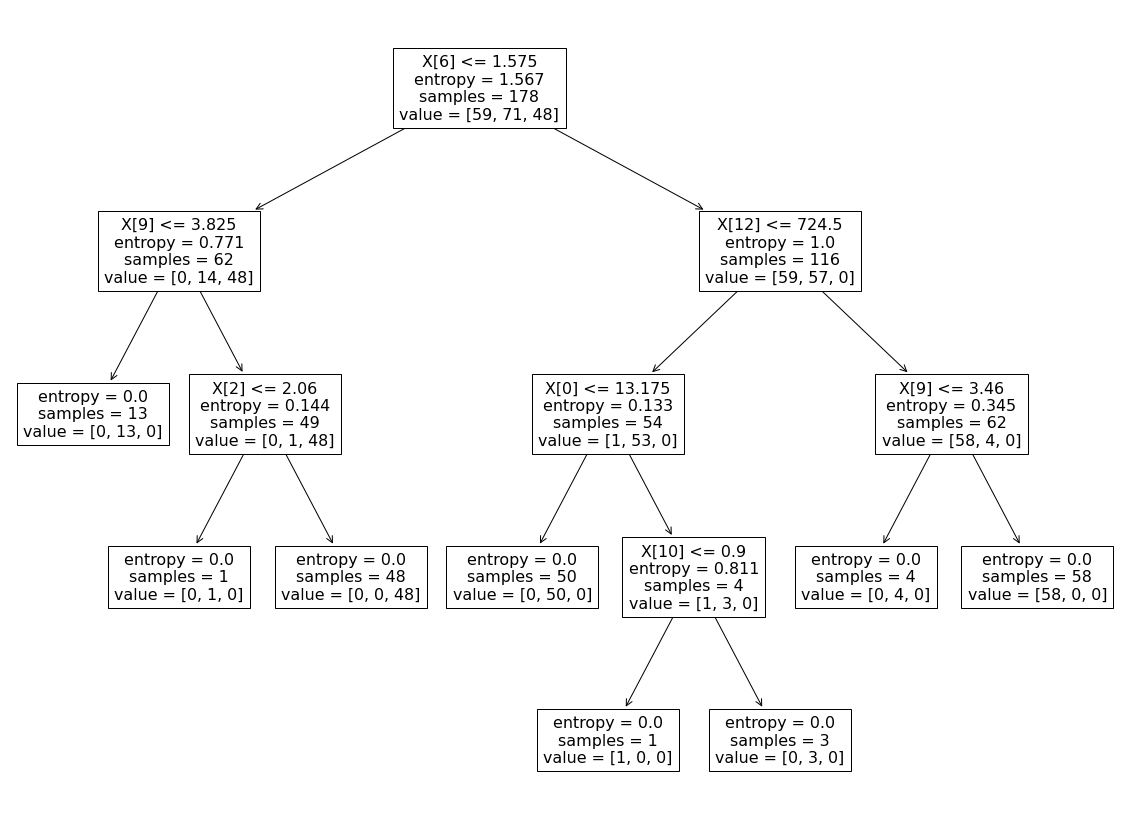

In [125]:
import matplotlib.pyplot as plt
from sklearn import tree

clf = tree.DecisionTreeClassifier(criterion='entropy')
wine = load_wine()

clf = clf.fit(wine.data, wine.target)
fig = plt.figure(figsize=(20,15))
_ = tree.plot_tree(clf)

In [126]:
dt.root.feature

6

In [127]:
dt.root.left.feature

9

In [128]:
dt.root.right.feature

12